In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

* Aggregating answers from many independent sources can outperform a single expert; this idea is known as the **wisdom of the crowd**

* The same principle applies to machine learning: combining predictions from multiple models often gives better performance than the best single model

* A **group of predictors** (classifiers or regressors) is called an **ensemble**

* The approach of training and combining multiple predictors is called **ensemble learning**

* An algorithm that implements ensemble learning is called an **ensemble method**

* Example of an ensemble method:

  * Train multiple **decision tree classifiers**
  * Each tree is trained on a **different random subset** of the training data
  * Each individual tree makes a prediction
  * Final prediction is obtained by **majority voting**
  * The class with the **most votes** becomes the ensemble’s output

* An ensemble of decision trees trained on random subsets is called a **Random Forest**

* Random forests are:

  * Simple in concept
  * Extremely powerful in practice
  * Among the most effective machine learning algorithms available

* In real ML projects:

  * Ensemble methods are often applied **near the end of a project**
  * Used after building several **reasonably good individual models**
  * Goal is to **combine them into a stronger predictor**

* In machine learning competitions:

  * Top-performing solutions frequently rely on **multiple ensemble methods**
  * A famous example is the **Netflix Prize**, where ensembles played a key role

* Common ensemble methods covered in this chapter:

  * Voting classifiers
  * Bagging and pasting ensembles
  * Random forests
  * Boosting
  * Stacking ensembles


# Voting Classifiers

* You can improve performance by combining several trained classifiers, each with around **80% accuracy**, into a single model

* Example base classifiers:

  * Logistic Regression
  * Support Vector Machine (SVM)
  * Random Forest
  * k-Nearest Neighbors (k-NN)
  * Other diverse models

* A simple ensemble strategy is to **aggregate predictions** from all classifiers

* The predicted class is the one that receives the **most votes**

* This approach is called **majority voting**

* A classifier that uses majority voting is called a **hard voting classifier**

* Hard voting classifiers often achieve **higher accuracy than the best individual classifier** in the ensemble

* Even if each classifier is a **weak learner** (only slightly better than random guessing):

  * The ensemble can still be a **strong learner**
  * Conditions required:

    * A **sufficiently large number** of weak learners
    * **Sufficient diversity** among learners (different models, errors)

* Intuition behind ensemble strength:

  * Analogy with a **biased coin**
  * Coin has:

    * Probability(heads) = 0.51
    * Probability(tails) = 0.49
  * Tossing the coin many times leads to:

    * Majority of heads in most experiments

* Probability behavior with biased coin:

  * 1,000 tosses → probability of majority heads ≈ **75%**
  * 10,000 tosses → probability of majority heads > **97%**
  * More trials → higher confidence in majority outcome

* This phenomenon is explained by the **Law of Large Numbers**

  * As the number of trials increases:

    * Observed frequency approaches true probability
    * Ratio of heads approaches **51%**

* Visualization insight (Figure reference):

  * Multiple sequences of coin tosses converge toward the true probability
  * Eventually all sequences stay above 50%

* Mapping analogy to machine learning:

  * Each classifier ≈ biased coin (e.g., **51% accuracy**)
  * Ensemble of 1,000 such classifiers:

    * Majority voting can reach up to **~75% accuracy**
  * This improvement assumes **perfect independence** between classifiers

* Practical limitation:

  * Classifiers are usually trained on the **same dataset**
  * Their errors are **correlated**
  * Many models may make the **same mistakes**
  * Correlated errors reduce ensemble performance

* Key requirement for effective voting ensembles:

  * Classifiers should make **uncorrelated errors**
  * Diversity is more important than individual accuracy

* Scikit-Learn support:

  * `VotingClassifier` class is provided for ensemble voting
  * Usage:

    * Provide a list of `(name, estimator)` pairs
    * Train and use it like a standard classifier

* Example experiment setup:

  * Use the **moons dataset**
  * Split into training and test sets
  * Build a voting classifier with **three diverse classifiers**


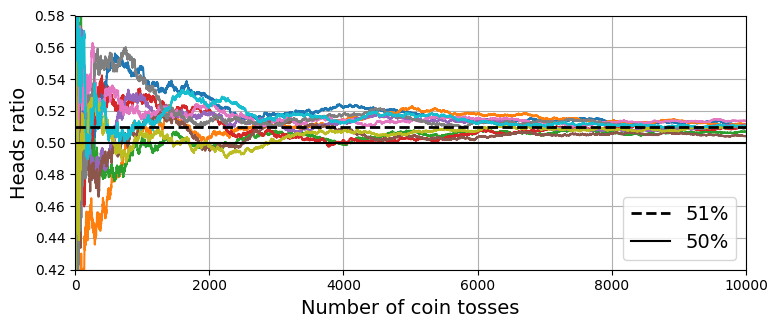

In [3]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('rf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [10]:
voting_clf.named_estimators_

{'lr': LogisticRegression(random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [11]:
voting_clf.predict(X_test[:1])

array([1])

In [12]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [13]:
voting_clf.estimators_

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 SVC(random_state=42)]

In [14]:
voting_clf.score(X_test, y_test)

0.912

In [15]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

* When a `VotingClassifier` is fitted:

  * It **clones each estimator** before training
  * The **original (unfitted) estimators** are stored in:

    * `estimators`
  * The **fitted cloned estimators** are stored in:

    * `estimators_`

* Accessing estimators:

  * If estimators are passed as a **list of (name, estimator)**:

    * Use `estimators` and `estimators_`
  * If a **dictionary-like access** is preferred:

    * Use `named_estimators` (original estimators)
    * Use `named_estimators_` (fitted estimators)

* Evaluating individual classifiers in the ensemble:

  * Loop through `named_estimators_`
  * Measure accuracy using `.score(X_test, y_test)`
  * Example observed accuracies:

    * Logistic Regression ≈ **0.864**
    * Random Forest ≈ **0.896**
    * SVC ≈ **0.896**

* Behavior of `predict()` in a voting classifier:

  * By default, it performs **hard voting**
  * Each classifier predicts a class label
  * Final class = **majority vote**

* Example of hard voting prediction:

  * For a single test instance:

    * Two classifiers predict class `1`
    * One classifier predicts class `0`
  * Final ensemble prediction = **class 1**

* Performance of hard voting ensemble:

  * Voting classifier test accuracy ≈ **0.912**
  * Outperforms all individual classifiers

* **Hard voting**:

  * Uses **predicted class labels**
  * Each classifier has **equal weight**
  * Simple but effective

* **Soft voting**:

  * Uses **predicted class probabilities**
  * Averages probabilities across classifiers
  * Final prediction = class with **highest average probability**
  * More confident predictions have **greater influence**

* Soft voting often outperforms hard voting because:

  * It accounts for **confidence levels** of classifiers
  * Reduces the impact of uncertain predictions

* Requirements for soft voting:

  * All classifiers must implement `predict_proba()`
  * Some classifiers (e.g., `SVC`) do **not** support this by default

* Enabling probability estimates for SVC:

  * Set `probability = True`
  * Internally uses **cross-validation** to estimate probabilities
  * Trade-offs:

    * Slower training
    * Adds `predict_proba()` method

* Switching from hard to soft voting:

  * Set `voting = "soft"`
  * Ensure all estimators support probability estimation
  * Refit the voting classifier

* Performance of soft voting ensemble:

  * Test accuracy ≈ **0.92**
  * Improvement over hard voting

* Key takeaway:

  * Voting ensembles can significantly outperform individual models
  * **Soft voting** is usually preferred when probability estimates are available


# Bagging and Pasting

* Diversity among classifiers can be achieved in multiple ways:

  * Using **different training algorithms** (e.g., LR, SVM, trees)
  * Using the **same algorithm** but training each predictor on **different random subsets** of the training data

* Training the same model on different subsets leads to:

  * Reduced correlation between predictors
  * More diverse errors across models

* **Bagging (Bootstrap Aggregating)**:

  * Training data is sampled **with replacement**
  * The same training instance:

    * Can appear **multiple times** in the same subset
    * Can appear across **multiple predictors**

* **Pasting**:

  * Training data is sampled **without replacement**
  * The same training instance:

    * Can appear across **multiple predictors**
    * **Cannot** appear more than once in the same predictor’s training set

* Key distinction:

  * Both bagging and pasting reuse training instances across predictors
  * Only **bagging** allows repeated instances **within a single predictor’s dataset**

* Bagging and pasting workflow:

  * Randomly sample subsets of the training data
  * Train one predictor per subset
  * Repeat for many predictors
  * Aggregate predictions at inference time

* Prediction aggregation:

  * **Classification**:

    * Use **statistical mode**
    * Equivalent to **hard voting**
  * **Regression**:

    * Use **average** of predictions

* Bias–variance behavior:

  * Each individual predictor:

    * Has **higher bias** than a model trained on the full dataset
  * Ensemble aggregation:

    * **Reduces variance**
    * Also reduces **overall error**
  * Net effect:

    * **Similar bias**
    * **Lower variance** than a single predictor trained on the full dataset

* Parallelization advantages:

  * Each predictor is trained **independently**
  * Training can be done:

    * On multiple CPU cores
    * On different machines or servers
  * Prediction can also be parallelized

* Practical benefits:

  * Excellent **scalability**
  * Efficient for large datasets
  * One of the main reasons **bagging and pasting are widely used**


## Bagging and Pasting in Scikit-Learn

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeClassifier`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeClassifier()
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",500
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",100
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",1.0
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",False
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",False
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `... versionadded:: 0.17 *warm_start* constructor parameter.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


In [17]:
bag_clf.predict(X_test)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [18]:
bag_clf.score(X_test,y_test)

0.904

* Scikit-Learn provides a unified API for **bagging and pasting** via:

  * `BaggingClassifier` (for classification)
  * `BaggingRegressor` (for regression)

* Core idea:

  * Train **many base estimators** (e.g., decision trees)
  * Each estimator is trained on a **random subset** of the training data
  * Final prediction is obtained by **aggregating all estimators’ predictions**

* Example setup (conceptual):

  * Base estimator: **DecisionTreeClassifier**
  * Number of estimators (`n_estimators`): **500**
  * Number of samples per estimator (`max_samples`): **100**
  * Sampling method:

    * With replacement → **bagging** (default)
    * Without replacement → **pasting** (`bootstrap=False`)

* Important `BaggingClassifier` parameters:

  * `n_estimators`:

    * Number of base predictors in the ensemble
    * More estimators → lower variance (but higher computation cost)
  * `max_samples`:

    * Number of training instances drawn for each predictor
  * `bootstrap`:

    * `True` → bagging (sampling with replacement)
    * `False` → pasting (sampling without replacement)
  * `n_jobs`:

    * Number of CPU cores used for training and prediction
    * `-1` → use **all available CPU cores**
  * `random_state`:

    * Ensures reproducibility of results

* Voting behavior in `BaggingClassifier`:

  * Automatically uses **soft voting** if the base estimator supports
    `predict_proba()`
  * Decision trees support probability estimation by default
  * Otherwise, falls back to **hard voting**

* Comparison: single decision tree vs bagging ensemble

  * Single decision tree:

    * Highly irregular decision boundary
    * High variance
    * Prone to overfitting
  * Bagging ensemble (e.g., 500 trees):

    * Much smoother decision boundary
    * Better generalization to unseen data
    * Similar bias but **lower variance**

* Bias–variance characteristics:

  * Individual bagged predictors:

    * Slightly higher bias (trained on smaller subsets)
  * Ensemble effect:

    * Strong reduction in variance
    * Overall error decreases
  * Net result:

    * Comparable bias to a single tree
    * Significantly lower variance

* Bagging vs pasting:

  * Bagging:

    * Introduces more diversity due to sampling with replacement
    * Predictors are less correlated
    * Slightly higher bias
    * Lower variance
  * Pasting:

    * Less diversity
    * Predictors more correlated
    * Slightly lower bias
    * Higher variance compared to bagging

* Practical recommendation:

  * **Bagging usually performs better** and is generally preferred
  * If computational resources allow:

    * Use **cross-validation**
    * Compare bagging vs pasting
    * Choose the method with better validation performance


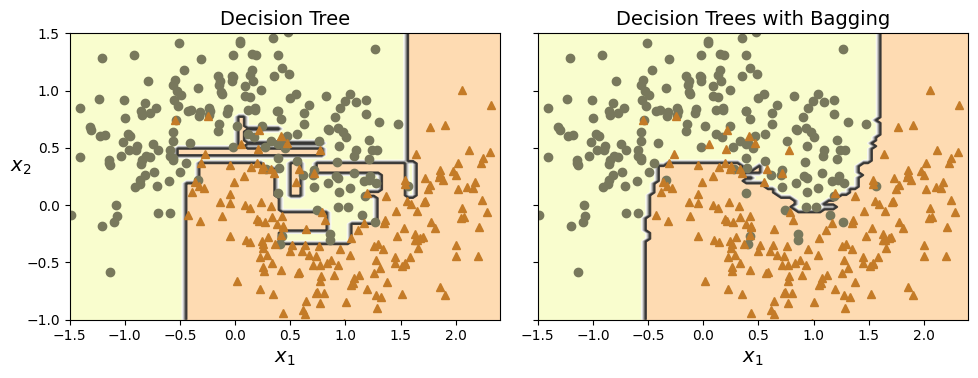

In [19]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag Evaluation

In [20]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

* In **bagging**, training instances are sampled **with replacement**

  * Some instances may appear **multiple times** in one predictor’s training set
  * Some instances may **not appear at all** for that predictor

* Default behavior of `BaggingClassifier`:

  * `bootstrap = True`
  * Number of sampled instances per predictor `m = size of training set`

* Statistical property of bootstrap sampling:

  * On average, only about **63%** of training instances are sampled for a given predictor
  * About **37%** of training instances are **not sampled**

* **Out-of-Bag (OOB) instances**:

  * The ~37% of training instances not selected for a given predictor
  * Different predictors have **different OOB subsets**

* Key advantage of OOB samples:

  * Enable **model evaluation without a separate validation set**
  * Saves data and computation

* OOB evaluation intuition:

  * With enough estimators:

    * Each training instance is an OOB sample for **multiple predictors**
  * These predictors can:

    * Make predictions for that instance
    * Be combined into an **ensemble prediction**
  * This gives a fair estimate of generalization performance

* OOB evaluation process:

  * Collect predictions from all predictors where the instance is OOB
  * Aggregate these predictions
  * Compute accuracy or other metrics on the training set using OOB predictions

* Enabling OOB evaluation in Scikit-Learn:

  * Set `oob_score = True` in `BaggingClassifier`
  * OOB evaluation is performed **automatically after training**

* Accessing OOB results:

  * Overall OOB accuracy:

    * Stored in `oob_score_`
  * Example:

    * OOB accuracy ≈ **0.896** (89.6%)

* Interpretation of OOB score:

  * Estimates expected performance on unseen test data
  * Often close to test accuracy, but may be:

    * Slightly pessimistic
    * Slightly optimistic (depends on data and model)

* Example comparison:

  * OOB accuracy ≈ **89.6%**
  * Test accuracy ≈ **92%**
  * OOB estimate was about **2% lower** than actual test performance

* OOB decision function:

  * Available via `oob_decision_function_`
  * Provides predictions **for each training instance** using only OOB estimators

* When base estimator supports probability estimation:

  * `oob_decision_function_` returns **class probabilities**
  * Shape:

    * `(n_samples, n_classes)`

* Example interpretation of OOB probabilities:

  * For a binary classification instance:

    * Positive class probability ≈ **67.6%**
    * Negative class probability ≈ **32.4%**

* Practical benefits of OOB evaluation:

  * No need for a validation split
  * Efficient use of training data
  * Especially useful for **large bagging ensembles**


In [21]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [22]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

>If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [23]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


## Random Patches and Random Subspaces

* `BaggingClassifier` can perform **feature sampling** in addition to instance sampling

* Feature sampling helps create **more diverse predictors**

* Feature sampling is controlled by two hyperparameters:

  * `max_features`
  * `bootstrap_features`

* These hyperparameters behave similarly to:

  * `max_samples`
  * `bootstrap`

* Key difference:

  * `max_samples` / `bootstrap` → sample **training instances**
  * `max_features` / `bootstrap_features` → sample **input features**

* How feature sampling works:

  * Each predictor is trained on a **random subset of features**
  * Different predictors see **different feature subsets**

* Benefits of feature sampling:

  * Increases **model diversity**
  * Reduces **correlation** between predictors
  * Often leads to **lower ensemble variance**

* Feature sampling is especially useful when:

  * Input data is **high-dimensional**
  * Example: image data with thousands of features
  * Training becomes significantly **faster**

* **Random Patches method**:

  * Sample **both training instances and features**
  * Combines:

    * Instance sampling (`max_samples`, `bootstrap`)
    * Feature sampling (`max_features`, `bootstrap_features`)
  * Produces highly diverse predictors

* **Random Subspaces method**:

  * Keep **all training instances**

    * `bootstrap = False`
    * `max_samples = 1.0`
  * Sample only **features**

    * `bootstrap_features = True` and/or `max_features < 1.0`
  * Useful when instances are few but features are many

* Bias–variance trade-off with feature sampling:

  * Feature sampling:

    * Slightly **increases bias**
    * Significantly **reduces variance**
  * Net effect:

    * Often better generalization performance


# Random Forests

* A **Random Forest** is an ensemble of **decision trees**

* Trees are generally trained using:

  * **Bagging** (sampling with replacement)
  * Sometimes **pasting** (sampling without replacement)

* Typically:

  * `max_samples` is set to the **size of the training set**

* Instead of manually using:

  * `BaggingClassifier` + `DecisionTreeClassifier`

* Scikit-Learn provides a specialized and optimized class:

  * `RandomForestClassifier`
  * `RandomForestRegressor` (for regression)

* Advantages of `RandomForestClassifier`:

  * More **convenient**
  * Highly **optimized for decision trees**
  * Standard implementation used in practice

* Example configuration:

  * Number of trees (`n_estimators`) = **500**
  * Maximum number of leaf nodes per tree (`max_leaf_nodes`) = **16**
  * Uses **all available CPU cores** (`n_jobs = -1`)
  * Reproducible results via `random_state`

* Training and prediction workflow:

  * Fit the random forest on training data
  * Predict labels on test data

* Hyperparameters in Random Forest:

  * Includes nearly all hyperparameters of:

    * `DecisionTreeClassifier` (tree structure, depth, splits, leaves)
    * `BaggingClassifier` (ensemble behavior, sampling)
  * Gives fine-grained control over:

    * Individual trees
    * Overall ensemble

* Extra randomness introduced by Random Forests:

  * When splitting a node:

    * Does **not** consider all features
    * Considers only a **random subset of features**
  * Chooses the best split **within this subset**

* Feature sampling at each split:

  * Increases **tree diversity**
  * Reduces **correlation** between trees

* Bias–variance trade-off in Random Forests:

  * Extra randomness:

    * Slightly **increases bias**
    * Strongly **reduces variance**
  * Net result:

    * Usually **better generalization performance**

* Default feature sampling behavior:

  * Samples a subset of features at each split
  * Subset size is a function of the total number of features

* Conceptual equivalence:

  * A RandomForestClassifier is equivalent to:

    * A `BaggingClassifier`
    * Using `DecisionTreeClassifier`
    * With **feature sampling enabled at each split**
  * Difference:

    * Random Forest applies feature sampling **inside the tree growth**, not just at dataset level


In [24]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [25]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [26]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

np.True_

## Extra-Trees

* In a **random forest**, when growing each decision tree:

  * At every node, only a **random subset of features** is considered for splitting
  * This adds randomness and reduces correlation between trees

* Additional source of randomness:

  * Instead of searching for the **best possible threshold** for a feature
  * Use **random thresholds** for splits

* Enabling random thresholds in decision trees:

  * Set `splitter = "random"` in `DecisionTreeClassifier`
  * Thresholds are chosen **randomly** rather than optimized

* **Extremely Randomized Trees (Extra-Trees)**:

  * Ensemble of decision trees with:

    * Random feature selection at each node
    * Random split thresholds
  * Also known as **Extra-Trees**

* Bias–variance trade-off in Extra-Trees:

  * More randomness:

    * **Higher bias**
    * **Lower variance**
  * Often leads to strong generalization despite higher bias

* Training speed advantage:

  * Extra-Trees are **much faster** to train than Random Forests
  * Reason:

    * Avoids expensive search for the best split threshold
    * Random thresholds significantly reduce computation

* Scikit-Learn implementation:

  * `ExtraTreesClassifier`
  * `ExtraTreesRegressor`

* API consistency:

  * `ExtraTreesClassifier` API ≈ `RandomForestClassifier` API
  * `ExtraTreesRegressor` API ≈ `RandomForestRegressor` API

* Default difference in behavior:

  * Random Forest:

    * `bootstrap = True` by default
  * Extra-Trees:

    * `bootstrap = False` by default

* Practical guidance:

  * Performance comparison between Random Forests and Extra-Trees is **data-dependent**
  * There is no universal winner

* Recommended approach:

  * Train both models
  * Compare using **cross-validation**
  * Select the model with better validation performance


## Feature Importance

In [27]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


In [28]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

* A key advantage of **Random Forests** is their ability to measure **feature importance**

* Feature importance helps identify:

  * Which input features contribute most to predictions
  * Which features may be less useful or redundant

* How Scikit-Learn computes feature importance:

  * Based on **impurity reduction**
  * Measures how much a feature:

    * Reduces impurity (e.g., Gini or entropy)
    * At nodes where it is used for splitting
  * Computed **across all trees** in the forest

* Precise definition:

  * Feature importance is a **weighted average** of impurity reductions
  * Weight of each node = **number of training samples** reaching that node

* Post-processing of importance scores:

  * Scikit-Learn automatically computes the scores after training
  * Scores are **normalized**

    * Sum of all feature importances = **1**

* Accessing feature importance values:

  * Available via the `feature_importances_` attribute
  * One value per input feature

* Example: Iris dataset

  * Train a `RandomForestClassifier` on iris data
  * Output shows relative importance of each feature

* Observed feature importances (approximate):

  * Petal length → **0.44**
  * Petal width → **0.42**
  * Sepal length → **0.11**
  * Sepal width → **0.02**

* Interpretation:

  * **Petal features** dominate classification decisions
  * **Sepal features** contribute relatively little

* Feature importance on high-dimensional data:

  * Example: MNIST dataset
  * Each pixel is treated as a feature
  * Random Forest importance visualization highlights:

    * Pixels that most influence digit classification

* Practical uses of feature importance:

  * Quick **interpretability** of models
  * Understanding **what features matter**
  * Guiding **feature selection**
  * Reducing dimensionality by removing low-importance features


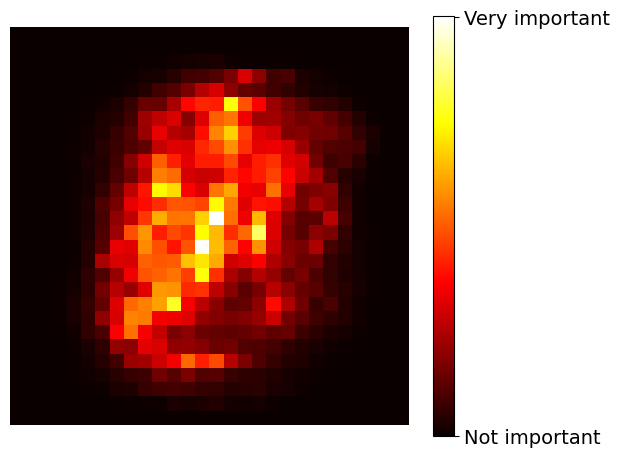

In [29]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting

>Boosting (originally called hypothesis boosting) refers to any ensemble
method that can combine several weak learners into a strong learner. The
general idea of most boosting methods is to train predictors sequentially, each
trying to correct its predecessor. There are many boosting methods available,
but by far the most popular are AdaBoost⁠ (short for adaptive boosting) and
gradient boosting. Let’s start with AdaBoost

## AdaBoost

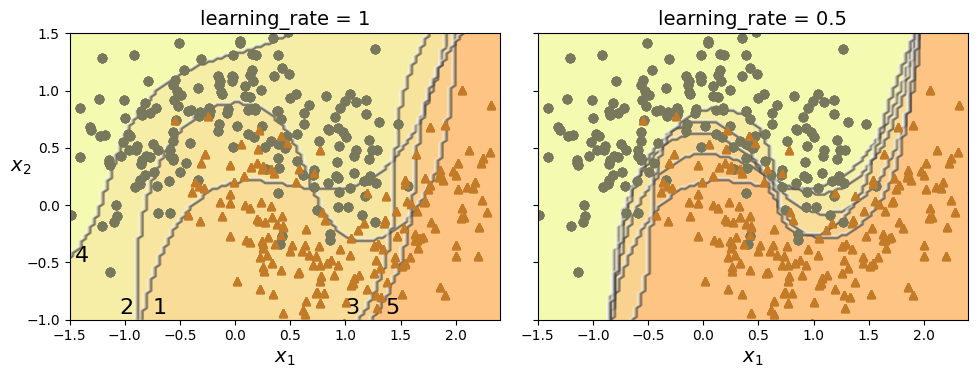

In [30]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

>There is one important drawback to this sequential learning technique: training cannot be
parallelized since each predictor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bagging or pasting

* **Boosting** is an ensemble technique where predictors are trained **sequentially**

* Each new predictor focuses more on the **mistakes made by previous predictors**

* Core idea of **AdaBoost (Adaptive Boosting)**:

  * Pay more attention to **hard-to-predict (underfit) training instances**
  * Gradually improve performance by correcting predecessors

* AdaBoost training process:

  * Train the **first base classifier** on the original training set
  * Use it to make predictions on the training data
  * **Increase weights** of misclassified instances
  * Train the **next classifier** using these updated weights
  * Repeat this process for many iterations

* Effect of instance reweighting:

  * Misclassified instances become **more influential**
  * Subsequent classifiers focus more on **hard cases**
  * Easy instances gradually receive less attention

* Visualization intuition (moons dataset example):

  * Sequence of predictors shows:

    * Early predictors make many errors
    * Later predictors progressively correct them
  * Each predictor improves performance on previously misclassified points

* Base learners in the example:

  * Highly regularized **SVM classifiers**
  * Using **RBF kernel**

* Role of the **learning rate** in AdaBoost:

  * Controls how much instance weights are increased after misclassification
  * Lower learning rate:

    * Smaller weight updates
    * Slower, more conservative learning
    * Often better generalization

* Comparison with gradient descent:

  * Similarity:

    * Both improve performance **iteratively**
    * Both focus on reducing errors over time
  * Difference:

    * Gradient descent:

      * Adjusts parameters of a **single model**
    * AdaBoost:

      * **Adds new predictors** to the ensemble at each iteration

* After training is complete:

  * Predictions are aggregated similar to bagging or pasting
  * Key difference:

    * Each predictor has a **different weight**
    * Predictor weight depends on its **accuracy on the weighted training set**

* Final ensemble prediction:

  * Weighted vote (classification)
  * More accurate predictors have **greater influence**


---

* **AdaBoost (Adaptive Boosting)** builds predictors **sequentially**

* Each new predictor focuses more on instances that previous predictors **misclassified**

* Initialization:

  * Each training instance weight is initialized equally
  *  For `m` training instances:

    w(i) = 1 / m

* Step 1: Train the j-th predictor

  * Train a base classifier using the **current instance weights**

* Step 2: Compute the **weighted error rate**

  * Measures how well the predictor performs on weighted data
  * Misclassified instances contribute more if their weights are high

* **Weighted error rate formula**:

  rⱼ = ∑ (w(i)) for all i where ŷⱼ(i) ≠ y(i)

  * ŷⱼ(i) → prediction of the j-th predictor for instance i
  * y(i) → true label of instance i
  * w(i) → current weight of instance i

* Step 3: Compute the **predictor weight**

  * Determines how much influence this predictor has in the final ensemble
  * Depends on its accuracy

* **Predictor weight formula**:

  αⱼ = η · log( (1 − rⱼ) / rⱼ )

  * η → learning rate (default = 1)
  * More accurate predictor → larger αⱼ
  * Random guessing (rⱼ ≈ 0.5) → αⱼ ≈ 0
  * Worse than random guessing → αⱼ < 0

* Step 4: Update instance weights

  * Correctly classified instances:

    * Weight remains unchanged
  * Misclassified instances:

    * Weight is **increased exponentially**

* **Weight update rule**:

  if ŷⱼ(i) = y(i):
    w(i) ← w(i)

  if ŷⱼ(i) ≠ y(i):
    w(i) ← w(i) · exp(αⱼ)

* Step 5: Normalize instance weights

  * Divide each weight by:

    ∑ᵢ w(i)

  * Ensures all weights sum to 1

* Repeat process:

  * Train next predictor using updated weights
  * Compute its error
  * Compute its weight
  * Update instance weights again

* Stopping criteria:

  * Desired number of predictors reached
  * A **perfect predictor** is found (zero error)

* Final prediction mechanism:

  * Each predictor casts a **weighted vote**
  * Predictors with higher αⱼ have more influence

* **Final AdaBoost prediction formula**:

  ŷ(x) = argmaxₖ ∑ⱼ αⱼ · I( ŷⱼ(x) = k )

  * N → number of predictors
  * I(·) → indicator function (1 if true, 0 otherwise)
  * Class with highest total weighted vote is chosen

* Multiclass AdaBoost in Scikit-Learn:

  * Uses **SAMME** (Stagewise Additive Modeling using a Multiclass Exponential loss)
  * For binary classification:

    * SAMME ≡ AdaBoost

* Probability-based variant:

  * **SAMME.R**
  * Used when base estimators support `predict_proba()`
  * Uses class probabilities instead of hard predictions
  * Generally achieves **better performance**

* Default base estimator in Scikit-Learn:

  * **Decision stump**
  * Decision tree with:

    * `max_depth = 1`
    * One split node + two leaf nodes

* Practical intuition:

  * AdaBoost turns many **weak learners** into a **strong learner**
  * Focuses learning power where the model struggles most


---



---

* **Initial instance weights**

$$[
w_i = \frac{1}{m}, \quad i = 1, 2, \dots, m
]$$

---

* **Weighted error rate of the (j^{th}) predictor**

$$[
r_j = \sum_{i=1}^{m} w_i \cdot \mathbf{1}\big(\hat{y}_j(i) \neq y(i)\big)
]$$

where

* ( $\hat{y}_j(i)$) = prediction of predictor (j) for instance (i)
* ( y(i) ) = true label
* ( $\mathbf{1}(\cdot)$ ) = indicator function
---

* **Predictor weight**

$$[
\alpha_j = \eta \cdot \ln\left(\frac{1 - r_j}{r_j}\right)
]$$

where

* ( $\eta )$ = learning rate (default = 1)

---

* **Instance weight update rule**

$$[
w_i \leftarrow
\begin{cases}
w_i, & \text{if } \hat{y}_j(i) = y(i) \
w_i \cdot e^{\alpha_j}, & \text{if } \hat{y}_j(i) \neq y(i)
\end{cases}
]$$

---

* **Weight normalization**

$$[
w_i \leftarrow \frac{w_i}{\sum_{k=1}^{m} w_k}
]$$

---

* **Final AdaBoost prediction**

$$[
\hat{y}(x) = \arg\max_{k} \sum_{j=1}^{N} \alpha_j \cdot \mathbf{1}\big(\hat{y}_j(x) = k\big)
]$$

where

* (N) = number of predictors

---


>If your AdaBoost ensemble is overfitting the training set, you can try reducing the number
of estimators or more strongly regularizing the base estimator.


In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeC...r(max_depth=1)
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",30
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",0.5
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None


In [32]:
ada_clf.predict(X_test)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [34]:
# ada_clf.predict_proba(X_test)

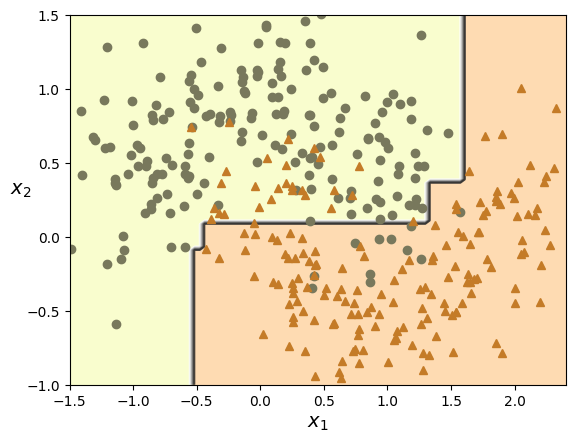

In [35]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting

In [36]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",43
,"max_leaf

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",44
,"max_leaf

In [39]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

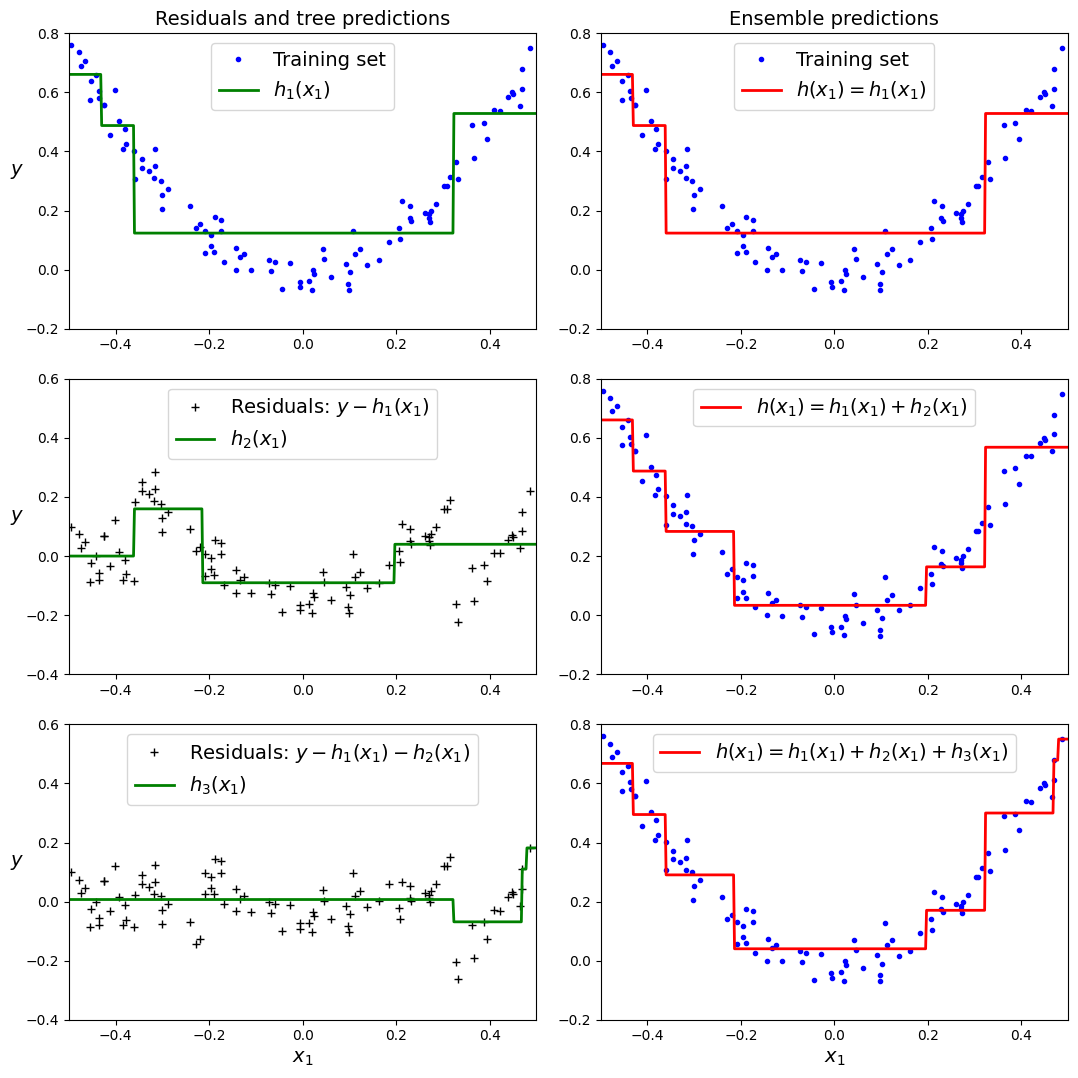

In [40]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

* **Gradient Boosting** is a popular boosting technique

* Like AdaBoost:

  * Predictors are added **sequentially**
  * Each new predictor corrects the mistakes of the previous ones

* Key difference from AdaBoost:

  * AdaBoost adjusts **instance weights**
  * Gradient Boosting fits new predictors to the **residual errors**

* Core idea:

  * At each step, train a new model to predict the **errors (residuals)** made by the current ensemble
  * Gradually reduce these residuals by adding models

* Regression version:

  * Called **Gradient Tree Boosting**
  * Also known as **Gradient Boosted Regression Trees (GBRT)**
  * Uses decision trees (usually shallow) as base learners

* Dataset example:

  * Input:

    $$[
    X \sim \text{Uniform}(-0.5, 0.5)
    ]$$

  * Target function:

    $$[
    y = 3x^2 + \text{Gaussian noise}
    ]$$

* Step 1: Train the first regressor

  * Fit a shallow decision tree to the original targets
  * This gives the initial prediction:

    $$[
    \hat{y}_1(x)
    ]$$

* Step 2: Compute residuals of the first model

  * Residuals represent what the model failed to learn:

    $$[
    r_2 = y - \hat{y}_1(x)
    ]$$

* Step 3: Train the second regressor

  * Fit a new tree to the residuals:

    $$[
    \hat{y}_2(x) \approx r_2
    ]$$

* Step 4: Compute new residuals

  * Errors after adding the second tree:

    $$[
    r_3 = r_2 - \hat{y}_2(x)
    ]$$

* Step 5: Train the third regressor

  * Fit another tree to the new residuals:

    $$[
    \hat{y}_3(x) \approx r_3
    ]$$

* General pattern after (k) trees:

  * Residual at step (k):

    $$[
    r_k = y - \sum_{i=1}^{k-1} \hat{y}_i(x)
    ]$$

* Final ensemble prediction:

  * Sum of predictions of all trees:

    $$[
    \hat{y}(x) = \sum_{i=1}^{N} \hat{y}_i(x)
    ]$$

* Prediction example:

  * New inputs:

    $$[
    X_{\text{new}} = [-0.4,\ 0,\ 0.5]
    ]$$

  * Final output is the **sum of predictions** from all trees in the ensemble

* Learning behavior:

  * First tree captures the **main structure**
  * Subsequent trees correct **remaining errors**
  * Predictions improve **gradually** as more trees are added

* Visual intuition (Figure reference):

  * Left column:

    * Predictions of individual trees
  * Right column:

    * Cumulative ensemble prediction
  * Each added tree refines the model

* Scikit-Learn implementation:

  * `GradientBoostingRegressor`
  * `GradientBoostingClassifier` (for classification)

* Hyperparameters fall into two groups:

  * Tree complexity control:

    * `max_depth`
    * `min_samples_leaf`
  * Ensemble control:

    * `n_estimators` (number of trees)

* Practical insight:

  * Gradient Boosting builds strong models from **many weak, shallow trees**
  * Extremely powerful, but sensitive to:

    * Overfitting
    * Hyperparameter tuning


---

* **Learning rate (`learning_rate`)**:

  * Scales the contribution of each tree added to the ensemble
  * Smaller values (e.g., `0.05`):

    * Require **more trees** to fit the training data
    * Usually lead to **better generalization**
  * Acts as a **regularization technique** called **shrinkage**

* Effect of number of trees:

  * Too few trees:

    * Model **underfits**
  * Right number of trees:

    * Good balance between bias and variance
  * Too many trees:

    * Model begins to **overfit** the training set

* Relationship between `learning_rate` and `n_estimators`:

  * Lower `learning_rate` → need higher `n_estimators`
  * Higher `learning_rate` → fewer trees, but higher overfitting risk

* Choosing the optimal number of trees:

  * Can use:

    * `GridSearchCV`
    * `RandomizedSearchCV`
  * But a simpler and efficient method is **early stopping**

* **Early stopping with `n_iter_no_change`**:

  * Stops training if the last *k* trees did not improve performance
  * Example:

    * `n_iter_no_change = 10`
    * Training stops if no improvement for 10 consecutive iterations
  * Prevents unnecessary trees from being added

* Early stopping intuition:

  * Allows a few non-improving steps (patience)
  * Stops before overfitting begins

* Example configuration:

  * Small learning rate (`0.05`)
  * Large maximum number of trees (`500`)
  * Early stopping decides the **actual** number of trees

* Result of early stopping:

  * Actual number of trees used:

    $$[
    n_{\text{estimators}} = 92
    ]$$

* Risk of improper `n_iter_no_change`:

  * Too small:

    * Training stops too early
    * Model **underfits**
  * Too large:

    * Model continues too long
    * Risk of **overfitting**

* Internal validation during early stopping:

  * When `n_iter_no_change` is set:

    * Training data is automatically split into:

      * Training subset
      * Validation subset
  * Validation performance is checked after adding each tree

* **Validation set size**:

  * Controlled by `validation_fraction`
  * Default:

    $\text{validation_fraction} = 0.1 \quad (10%)$

* **Tolerance parameter (`tol`)**:

  * Minimum improvement required to count as progress
  * Default:

    $$[
    \text{tol} = 0.0001
    ]$$
  * Improvements smaller than `tol` are considered negligible

* **Subsampling (`subsample`)**:

  * Fraction of training instances used to train each tree
  * Example:

    $$[
    \text{subsample} = 0.25
    ]$$

* Effect of subsampling:

  * Each tree sees only a **random subset** of training instances
  * Introduces extra randomness

* Bias–variance trade-off with subsampling:

  * Higher bias
  * Lower variance
  * Faster training

* Boosting variant using subsampling:

  * Called **Stochastic Gradient Boosting**
  * Combines:

    * Gradient boosting
    * Random sampling of instances


In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",1.0
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft ch

In [42]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",500
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [43]:
gbrt_best.n_estimators_

92

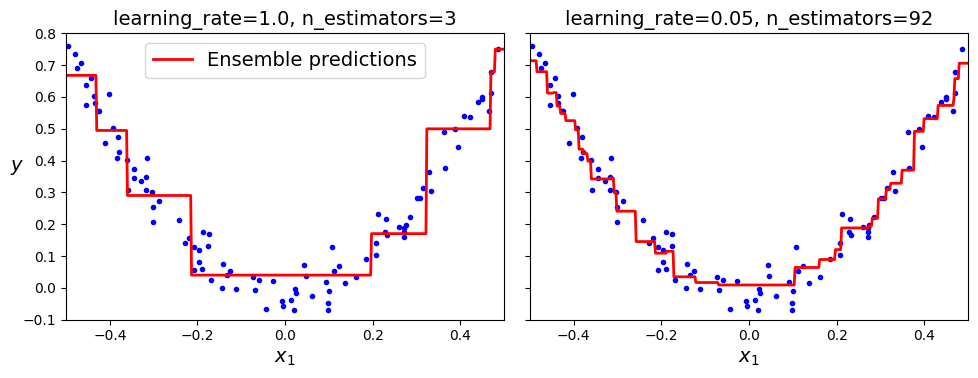

In [44]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

## Histogram-Based Gradient Boosting

* **Histogram-based Gradient Boosting (HGB)**:

  * Optimized version of GBRT for **large datasets**
  * Designed for **speed and memory efficiency**

* Core idea of HGB:

  * **Bin continuous features** into discrete integer values
  * Replace raw feature values with **bin indices**

* Feature binning:

  * Controlled by `max_bins`

  * Default:

    $$[
    \text{max_bins} = 255
    ]$$

  * Upper bound:

    * Cannot be set higher than 255

  * Reduces the number of candidate split thresholds

* Benefits of binning:

  * Fewer thresholds to evaluate
  * Faster split search
  * Lower memory usage
  * Enables use of efficient integer-based data structures
  * Eliminates the need to **sort features** at each split

* Computational complexity:

  * Standard GBRT:

    $$[
    O(n \cdot m \cdot \log m)
    ]$$

  * Histogram-based GBRT:

    $$[
    O(b \cdot m)
    ]$$

  * Where:

    * (n) = number of features
    * (m) = number of training instances
    * (b) = number of bins

* Practical impact:

  * HGB can train **hundreds of times faster** than regular GBRT on large datasets

* Trade-off of binning:

  * Causes **precision loss**
  * Acts as a form of **regularization**
  * Depending on the dataset:

    * Can reduce overfitting
    * Or cause underfitting

* Scikit-Learn HGB classes:

  * `HistGradientBoostingRegressor`
  * `HistGradientBoostingClassifier`

* Differences from standard Gradient Boosting classes:

  * **Early stopping**:

    * Automatically enabled when:

      $$[
      m > 10{,}000
      ]$$

    * Can be forced:

      * Always ON → `early_stopping=True`
      * Always OFF → `early_stopping=False`
  * **Subsampling**:

    * Not supported
  * **Renamed hyperparameter**:

    * `n_estimators` → `max_iter`
  * **Limited tree hyperparameters**:

    * `max_leaf_nodes`
    * `min_samples_leaf`
    * `max_depth`

* Additional advantages of HGB:

  * Supports **categorical features**
  * Supports **missing values**
  * Reduces preprocessing complexity

* Handling categorical features:

  * Must be encoded as integers:

    $$[
    0, 1, 2, \dots < \text{max_bins}
    ]$$

  * `OrdinalEncoder` is typically used

* Example pipeline (conceptual steps):

  * Encode categorical column(s) with `OrdinalEncoder`
  * Pass remaining numerical features directly
  * Train `HistGradientBoostingRegressor`

* Key pipeline benefits:

  * No need for:

    * Imputation
    * Feature scaling
    * One-hot encoding
  * Pipeline remains **compact and clean**

* Practical performance note:

  * Without hyperparameter tuning:

    * Achieves RMSE ≈ **47,600** on California housing dataset
  * Strong baseline with minimal setup


>Several other optimized implementations of gradient boosting are available in the Python
ML ecosystem: in particular, [XGBoost](https://github.com/dmlc/xgboost), [CatBoost](https://catboost.ai/), and [LightGBM](https://lightgbm.readthedocs.io/en/stable/). These libraries have
been around for several years. They are all specialized for gradient boosting, their APIs
are very similar to Scikit-Learn’s, and they provide many additional features, including
GPU acceleration; you should definitely check them out! Moreover, the [TensorFlow
Random Forests library](https://www.tensorflow.org/decision_forests) provides optimized implementations of a variety of random forest
algorithms, including plain random forests, extra-trees, GBRT, and several more.

In [45]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('histgradientboostingregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ordinalencoder', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output

In [47]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

# Stacking

* **Stacking (stacked generalization)** is an ensemble method

* Core idea:

  * Instead of using a simple aggregation rule (e.g., hard/soft voting)
  * **Train a model to aggregate predictions**
  * This model learns *how* to best combine base predictors

* Terminology:

  * **Base predictors** (level-0 models):

    * Original models in the ensemble
  * **Blender / Meta-learner** (level-1 model):

    * Learns to combine base predictor outputs
    * Produces the final prediction

* Prediction flow in stacking:

  * Each base predictor makes a prediction
  * These predictions become **input features** for the blender
  * Blender outputs the final prediction

* Regression intuition example:

  * Base predictions: 3.1, 2.7, 2.9
  * Blender input: ([3.1, 2.7, 2.9])
  * Final output: 3.0

* Training the blender (key challenge):

  * Blender must be trained on **out-of-sample predictions**
  * Prevents data leakage

* Building the blending training set:

  * Use `cross_val_predict()` on each base predictor
  * For each training instance:

    * Collect predictions made **only by models that did not see it**
  * These predictions form the new feature matrix

* Structure of blending dataset:

  * Input features:

    * One feature per base predictor
  * Targets:

    * Same targets as original training set
  * Independent of original feature dimensionality

* Training procedure summary:

  * Step 1: Use cross-validation to generate out-of-sample predictions
  * Step 2: Train the blender on these predictions
  * Step 3: Retrain all base predictors on the **full training set**
  * Step 4: Use base predictors + blender for inference

* Multi-layer stacking:

  * Possible to train:

    * Multiple blenders at one level
    * Another blender on top of them
  * Can yield small performance gains
  * Costs:

    * More training time
    * Increased system complexity

* Scikit-Learn stacking support:

  * `StackingClassifier`
  * `StackingRegressor`

* Key stacking hyperparameters:

  * `estimators`:

    * List of `(name, model)` base predictors
  * `final_estimator`:

    * The blender (meta-learner)
  * `cv`:

    * Number of cross-validation folds used to create blending data

* Prediction method selection in stacking:

  * Uses `predict_proba()` if available
  * Else uses `decision_function()`
  * Else falls back to `predict()`

* Default blenders:

  * `StackingClassifier` → `LogisticRegression`
  * `StackingRegressor` → `RidgeCV`

* Performance insight:

  * Stacking often outperforms voting
  * Example:

    * Soft voting accuracy ≈ 92%
    * Stacking accuracy ≈ **92.8%**

* Strengths of ensemble methods:

  * High performance
  * Flexible and robust
  * Minimal preprocessing required

* Practical recommendation:

  * First models to try for many problems:

    * Random Forests
    * AdaBoost
    * Gradient Boosting (GBRT)
  * Especially strong for:

    * Heterogeneous tabular data

* Final takeaway:

  * Voting → simple improvement
  * Stacking → **learned aggregation**
  * Best choice when pushing performance to its limits


In [48]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('lr', ...), ('rf', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",RandomForestC...ndom_state=43)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",5
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.

In [49]:
stacking_clf.score(X_test, y_test)

0.928

# Exercises

## 1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?

If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.

## 2. What is the difference between hard and soft voting classifiers?

A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set probability=True).

## 3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, random forests, or stacking ensembles?

It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.

## 4. What is the benefit of out-of-bag evaluation?

With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.

## 5. What makes extra-trees ensembles more random than regular random forests? How can this extra randomness help? Are extra-trees classifiers slower or faster than regular random forests?

When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don't search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions

## 6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak, and how?

If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.

## 7. If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?

If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).

## 8. Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [50]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Note: The `LinearSVC` has a `dual` hyperparameter whose default value will change from `True` to `"auto"` in Scikit-Learn 1.5. To ensure this notebook continues to produce the same outputs, I'm setting it explicitly to `True`. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for more details.

In [52]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [53]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [54]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9669]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

In [55]:
from sklearn.ensemble import VotingClassifier

In [56]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [57]:
voting_clf = VotingClassifier(named_estimators)

In [58]:
voting_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('random_forest_clf', ...), ('extra_trees_clf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1


In [59]:
voting_clf.score(X_valid, y_valid)

0.9754

The VotingClassifier made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a LabelEncoder:

In [60]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [61]:
y_valid_encoded = y_valid.astype(np.int64)

In [62]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9669]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to "drop" using set_params() like this:

In [63]:
voting_clf.set_params(svm_clf="drop")

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('random_forest_clf', ...), ('extra_trees_clf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1


In [64]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [65]:
# However, it did not update the list of trained estimators

In [66]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [67]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

So we can either fit the VotingClassifier again, or just remove the SVM from the list of trained estimators, both in estimators_ and named_estimators_:

In [68]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

In [69]:
voting_clf.score(X_valid, y_valid)

0.9768

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set voting to "soft":

In [70]:
voting_clf.voting = "soft"

In [71]:
voting_clf.score(X_valid, y_valid)

0.9727

In [72]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9722

In [73]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9638]

## 9. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set. Congratulations —you have just trained a blender, and together with the classifiers it forms a stacking ensemble! Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. How does it compare to the voting classifier you trained earlier? Now try again using a StackingClassifier instead. Do you get better performance? If so, why?

In [74]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [75]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], shape=(10000, 4), dtype=object)

In [76]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [77]:
rnd_forest_blender.oob_score_

0.9728

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

In [78]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [79]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [80]:
accuracy_score(y_test, y_pred)

0.9683

This stacking ensemble does not perform as well as the voting classifier we trained earlier.

Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [81]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Now let's create and train the stacking classifier on the full training set:

**Warning**: the following cell will take quite a while to run (15-30 minutes depending on your hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [82]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender,
                              verbose=1)
stack_clf.fit(X_train_full, y_train_full)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 65.7min finished


,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('random_forest_clf', ...), ('extra_trees_clf', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",RandomForestC...ndom_state=42)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",1
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, d

In [83]:
stack_clf.score(X_test, y_test)

0.9796

The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:

* Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
* It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.